# Scenarios and sampling

## Load Profile

In [29]:
import sys
sys.path.append('../sddip')

In [30]:
import os
import random as rdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sddip.config as config

## Load Profile Manipulation

In [31]:
load_profile_name = "h0_summer_workday.txt"
load_profiles_dir = "supplementary/load_profiles"


load_profile_dir = os.path.join(config.test_cases_dir, load_profiles_dir)

load_profile_file = os.path.join(load_profile_dir, load_profile_name)

profile_df = pd.read_csv(load_profile_file, delimiter="\t")

profile_df

,time,h0
0,00:15:00,86.3
1,00:30:00,76.9
2,00:45:00,68.8
3,01:00:00,62.4
4,01:15:00,58.0
...,...,...
91,23:00:00,135.7
92,23:15:00,127.2
93,23:30:00,117.5
94,23:45:00,107.1


<AxesSubplot:>

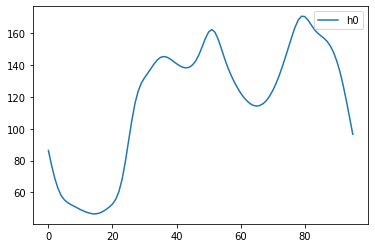

In [32]:
profile_df.plot()

<AxesSubplot:>

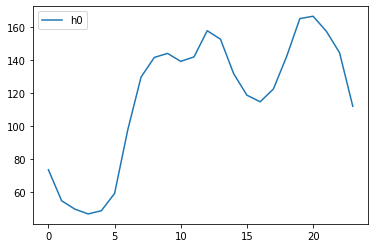

In [33]:
values = np.array(profile_df.h0.tolist())

reduction_factor = 4
if len(values)%reduction_factor!=0:
    raise ValueError("Number of values to be reduced must be divisible by the reduction factor.")

reduced_values = np.mean(values.reshape(-1,reduction_factor), axis=1)

reduced_profile_df = pd.DataFrame({"h0" : reduced_values})
reduced_profile_df.plot()

<AxesSubplot:>

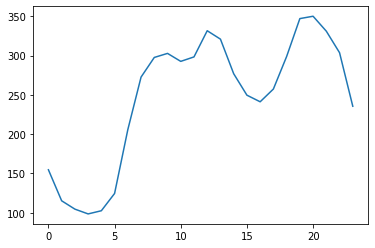

In [34]:
max_load = reduced_profile_df.h0.max()

scaling_factor = 350/max_load

scaled_profile = reduced_profile_df.h0*scaling_factor

scaled_profile.plot()

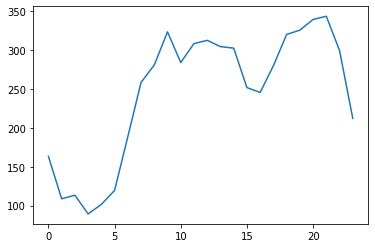

In [35]:

rdm_variation_profile = [p+p*rdm.uniform(-0.1,0.1) for p in scaled_profile]

plt.plot(rdm_variation_profile)

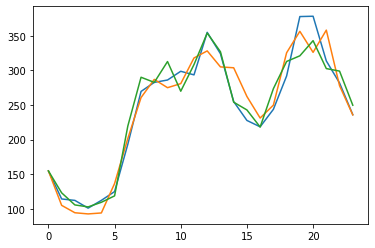

In [36]:
n_profiles = 3

profiles = [[p+p*rdm.uniform(-0.1,0.1) for p in scaled_profile] for _ in range(n_profiles)]

for profile in profiles:
    profile[0] = scaled_profile[0]

for i in range(n_profiles):
    plt.plot(profiles[i])

plt.show()

## Scenario generation

In [37]:
def get_rdm_variation(base_value, max_relative_variation = 0.1):
    return base_value+base_value*rdm.uniform(-max_relative_variation, max_relative_variation)

In [38]:
n_buses = 2
demand_buses = [1]
no_demand_buses = [b for b in range(n_buses) if  b not in demand_buses]

base_profile = scaled_profile

n_realizations_per_stage = 3
n_stages = len(base_profile)
n_total_ralizations = (n_stages-1)*n_realizations_per_stage + 1

scenario_data = {
    "t": [],
    "n": [],
    "p": []
}

demand_bus_keys = []
no_demand_bus_keys = []
for b in range(n_buses):
    bus_key = f"Pd{b+1}"
    scenario_data[bus_key] = []
    if b in demand_buses:
        demand_bus_keys.append(bus_key)
    else:
        scenario_data[bus_key] = [0]*n_total_ralizations
        no_demand_bus_keys.append(bus_key)



scenario_data["t"].append(1)
scenario_data["n"].append(1)
scenario_data["p"].append(1)

for db in demand_bus_keys:
    scenario_data[db].append(get_rdm_variation(base_profile[0]))


if n_stages < 2:
    raise ValueError("Number of stages must be greater than 1.")
if n_realizations_per_stage < 2:
    raise ValueError("Number of realizations per stage must be greater than 1.")

for t in range(1,n_stages):
    for n in range(1,n_realizations_per_stage+1):
        scenario_data[f"t"].append(t+1)
        scenario_data["n"].append(n)
        scenario_data["p"].append(1/n_realizations_per_stage)
        for db in demand_bus_keys:
            scenario_data[db].append(get_rdm_variation(base_profile[t]))


scenario_df = pd.DataFrame(scenario_data)
scenario_df

,t,n,p,Pd1,Pd2
0,1,1,1.000000,0,170.013191
1,2,1,0.333333,0,103.784909
2,2,2,0.333333,0,116.453382
3,2,3,0.333333,0,105.933885
4,3,1,0.333333,0,112.673108
...,...,...,...,...,...
65,23,2,0.333333,0,281.918999
66,23,3,0.333333,0,326.949688
67,24,1,0.333333,0,254.616515
68,24,2,0.333333,0,240.928476


## Sampling

In [39]:
n_samples = 2

samples = []
for _ in range(n_samples):
    sample = [rdm.randint(0,n_realizations_per_stage-1) for _ in range(n_stages-1)]
    sample.insert(0,0)
    samples.append(sample)

samples

[[0, 1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 2],
 [0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0]]

## External Scenario Module

In [40]:
import sddip.scenarios as scenarios

n_stages = 24
n_realizations_per_stage = 3

n_buses = 3
demand_buses = [1,2]
max_value_targets = [350, 200]


sc_generator = scenarios.ScenarioGenerator(n_stages, n_realizations_per_stage)

scenario_df = sc_generator.generate_scenario_dataframe(n_buses, demand_buses, max_value_targets)

scenario_df

,t,n,p,Pd1,Pd2,Pd3
0,1,1,1.000000,0,143.077389,83.203451
1,2,1,0.333333,0,125.498927,67.553057
2,2,2,0.333333,0,110.997959,63.207778
3,2,3,0.333333,0,110.464344,61.141577
4,3,1,0.333333,0,96.072028,60.651234
...,...,...,...,...,...,...
65,23,2,0.333333,0,320.230344,175.181264
66,23,3,0.333333,0,290.916775,185.016091
67,24,1,0.333333,0,230.577754,132.083062
68,24,2,0.333333,0,247.867267,126.572548


<AxesSubplot:>

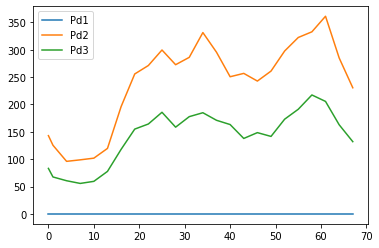

In [41]:
n = 1
realization_df = scenario_df[scenario_df["n"] == n]

profiles_df = realization_df.drop(["t","n", "p"], axis=1)

profiles_df.plot()

In [42]:
n_samples = 3

sc_sampler = scenarios.ScenarioSampler(n_stages, n_realizations_per_stage)

sc_sampler.generate_samples(n_samples)

[[0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1],
 [0, 2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0],
 [0, 0, 1, 0, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 1, 0, 1]]